In [1]:
import random, os, functools, statistics

import numpy as np
import matplotlib.pyplot as plt
import dill, joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from glio.train2 import *
from glio.train2.cbs_summary import Summary
from glio.visualize import vis_imshow, vis_imshow_grid, Visualizer
from glio.jupyter_tools import show_slices, show_slices_arr, clean_mem
from glio.torch_tools import area_around, one_hot_mask, summary, lr_finder, to_binary, count_parameters
from glio.python_tools import type_str, CacheRepeatIterator, get_all_files, listdir_fullpaths
from glio import nn as gnn
from glio.nn import conv, convt, linear, seq, block
from glio.data import DSToTarget
from glio.helpers import cnn_output_size, tcnn_output_size
from glio.loaders import nifti
from glio.transforms import fToChannels, fToChannelsFirst,fToChannelsLast, z_normalize, norm_to01, norm_to11, z_normalize_channels

from monai.losses.dice import DiceLoss, DiceFocalLoss
from monai.metrics.meandice import compute_dice
from monai.metrics.meaniou import compute_iou
from schedulefree import AdamWScheduleFree

inp.shape = torch.Size([13, 96, 96]), target.shape = torch.Size([4, 96, 96])
[i.mean() for i in inp] = [tensor(0.9383), tensor(1.0148), tensor(1.0540), tensor(0.9313), tensor(1.0204), tensor(1.1879), tensor(-0.7943), tensor(0.2186), tensor(-0.8365), tensor(0.9025), tensor(0.), tensor(0.0628), tensor(0.)], [i.std() for i in inp] = [tensor(0.9438), tensor(0.8836), tensor(1.0270), tensor(1.1107), tensor(0.9314), tensor(0.2930), tensor(0.2168), tensor(0.3779), tensor(0.2041), tensor(0.2967), tensor(0.), tensor(0.2427), tensor(0.)]
dstrain.get_preloaded_percent() = 1.0
len(dstrain) = 7023, len(dstest) = 761


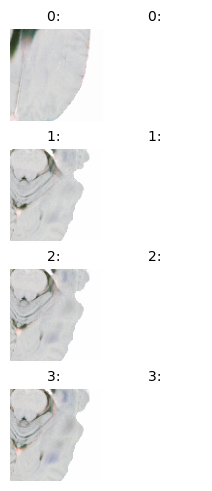

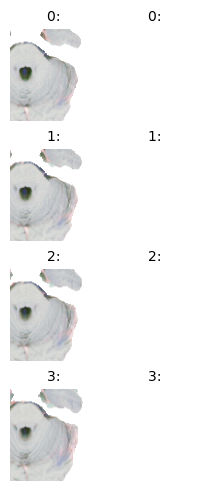

In [2]:
TITLE = "RHUH 2D segm refining"
PRELOAD = 0.

def get_center(npz):
    return (npz["center"][1], npz["center"][0])
def loader(path: str):
    npz = np.load(path)
    imgs = npz["img"][:4]
    ads = npz["img"][4]
    return (
        area_around(torch.cat(
                [
                    z_normalize_channels(torch.from_numpy(imgs)),
                    z_normalize(torch.from_numpy(ads)).unsqueeze(0),
                    z_normalize(torch.from_numpy(npz["preds"])),
                    (torch.from_numpy(npz["preds_binary"])),
                ], 0,), get_center(npz), (96, 96)).clone(),
        area_around(one_hot_mask(torch.from_numpy(npz["seg"]), 4), get_center(npz), (96, 96)).clone()
    )
# torch.Size([13, 96, 96])
# torch.Size([4, 96, 96])

def tfm_input(data):
    return data[0].to(torch.float32)

def tfm_target(data):
    return data[1]

img = loader(r"E:\dataset\RHUH-GBM 2D\images\RHUH-0001\1\RHUH-0001_1_64.npz")
inp = tfm_input(img)
target = tfm_target(img)

print(f"{inp.shape = }, {target.shape = }")
print(f"{[i.mean() for i in inp] = }, {[i.std() for i in inp] = }")

# dstrain = DSToTarget()
# dstest = DSToTarget()
# for obs in listdir_fullpaths(r"E:\dataset\RHUH-GBM 2D\images")[:36]:
#     dstrain.add_folder(obs, loader, None, tfm_input, tfm_target)
# for obs in listdir_fullpaths(r"E:\dataset\RHUH-GBM 2D\images")[36:]:
#     dstest.add_folder(obs, loader, None, tfm_input, tfm_target)
# dstrain.preload(PRELOAD, log=True, nthreads=8)
# dstest.preload(PRELOAD, log=True, nthreads=8)
dstrain:DSToTarget = joblib.load(r"F:\Stuff\Programming\experiments\vkr\RHUH 2d v2 refine TRAIN.joblib")
dstest:DSToTarget = joblib.load(r"F:\Stuff\Programming\experiments\vkr\RHUH 2d v2 refine TEST.joblib")

print(f"{dstrain.get_preloaded_percent() = }")
print(f"{len(dstrain) = }, {len(dstest) = }")
dstrain.preview()
dstest.preview()

def plot_preds(learner:Learner, batch, softmax = True, unsqueeze = True):
    batch = list(batch)
    if unsqueeze:
        batch[0] = batch[0].unsqueeze(0)
        batch[1] = batch[1].unsqueeze(0)
    preds = learner.inference(batch[0])
    v = Visualizer()
    v.imshow_grid(batch[0][0], mode="bhw", label="вход")
    v.imshow_grid(batch[1][0], mode="bhw", label = "реальная карта")
    if softmax:
        output = torch.stack([preds[0],preds[0],preds[0]], dim=1)
        output[:,0] *=  F.softmax(preds[0],0)
        v.imshow_grid(output, mode="bchw", label="сырой выход")
        v.imshow_grid(to_binary(F.softmax(preds[0], 0)), mode="bhw", label="предсказанная карта")
    else:
        v.imshow_grid(preds[0], mode="bchw", label="сырой выход")
        v.imshow_grid(to_binary(preds[0], 0), mode="bhw", label="предсказанная карта")
    v.show(figsize=(24, 24), nrows=1)

def eval_on_brats_2d(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    images = [loader(i) for i in get_all_files(folder)]
    inputs = torch.stack([tfm_input(i) for i in images])
    targets = torch.stack([tfm_target(i) for i in images])
    preds = learner.inference(inputs)
    preds_softmax = F.softmax(preds, 0)
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)
    t1 = torch.cat([norm_to01(inputs), norm_to01(targets), norm_to01(preds)], 3)
    t2 = torch.cat([norm_to01(preds_softmax), norm_to01(preds_binary), norm_to01(preds_binary_softmax)], 3)
    t = torch.cat([t1, t2], 2)
    show_slices(t)

def find_file_containing(folder, contains:str, recursive = True):
    for f in get_all_files(folder, recursive=recursive):
        if contains in f:
            return f
    raise FileNotFoundError(f"No file containing {contains} in {folder}")


from monai.inferers import SlidingWindowInfererAdapt # type:ignore
def eval_on_rhuh_slices(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    t1c = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t1ce")))
    t1n = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t1.")))
    t2f = z_normalize(nifti.niireadtensor(find_file_containing(folder, "flair")))
    t2w = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t2")))
    seg = one_hot_mask(nifti.niireadtensor(find_file_containing(folder, "seg")), 4).swapaxes(0,1)

    inputs = torch.stack([t1c, t1n, t2f, t2w]).swapaxes(0,1)
    inferer = SlidingWindowInfererAdapt(roi_size = (96,96), sw_batch_size = 32)
    preds = inferer(inputs, learner.inference)


    preds_softmax = F.softmax(preds, 0) # type:ignore
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)# type:ignore
    t1 = torch.cat([norm_to01(inputs), norm_to01(seg), norm_to01(preds)], 3)
    t2 = torch.cat([norm_to01(preds_softmax), norm_to01(preds_binary), norm_to01(preds_binary_softmax)], 3)
    t = torch.cat([norm_to01(t1), norm_to01(t2)], 2)
    show_slices(norm_to01(t))

def eval_on_brats_slices(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    t1c = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t1c")))
    t1n = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t1n")))
    t2f = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t2f")))
    t2w = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t2w")))
    seg = one_hot_mask(nifti.niireadtensor(find_file_containing(folder, "seg")), 4).swapaxes(0,1)

    inputs = torch.stack([t1c, t1n, t2f, t2w]).swapaxes(0,1)
    inferer = SlidingWindowInfererAdapt(roi_size = (96,96), sw_batch_size = 32)
    preds = inferer(inputs, learner.inference)


    preds_softmax = F.softmax(preds, 0) # type:ignore
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)# type:ignore
    t1 = torch.cat([norm_to01(inputs), norm_to01(seg), norm_to01(preds)], 3)
    t2 = torch.cat([norm_to01(preds_softmax), norm_to01(preds_binary), norm_to01(preds_binary_softmax)], 3)
    t = torch.cat([norm_to01(t1), norm_to01(t2)], 2)
    show_slices(norm_to01(t))


def eval_on_brats_slices_sep_arr(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    t1c = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t1c")).to(torch.float32))
    t1n = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t1n")).to(torch.float32))
    t2f = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t2f")).to(torch.float32))
    t2w = z_normalize(nifti.niireadtensor(find_file_containing(folder, "t2w")).to(torch.float32))
    seg = one_hot_mask(nifti.niireadtensor(find_file_containing(folder, "seg")), 4).swapaxes(0,1)

    inputs = torch.stack([t1c, t1n, t2f, t2w]).swapaxes(0,1)
    inferer = SlidingWindowInfererAdapt(roi_size = (96,96), sw_batch_size = 32, overlap=0.1)
    preds = inferer(inputs, learner.inference)


    preds_softmax = F.softmax(preds, 0) # type:ignore
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)# type:ignore
    show_slices_arr(torch.stack([inputs, seg, preds, preds_softmax, preds_binary, preds_binary_softmax]))

In [3]:
from monai.networks.nets import SegResNetDS # type:ignore

summary(SegResNetDS(2, in_channels=13, out_channels=4, init_filters=16), (8, 13, 96,96))

path                                         module                                       input size               output size              params    buffers   
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/conv_inittorch.nn.modules.conv.Conv2d                 (8, 13, 96, 96)          (8, 16, 96, 96)          1872      0         
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/norm1torch.nn.modules.batchnorm.BatchNorm2d       (8, 16, 96, 96)          (8, 16, 96, 96)          32        33        
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/act1torch.nn.modules.activation.ReLU             (8, 16, 96, 96)          (8, 16, 96, 96)          0         0         
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/conv1torch.nn.modules.conv.Conv2d                 (8, 16, 96, 96)          (8, 16, 96, 96)          2304      0         
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/norm2torch.nn.m

[-0.023, 0.151, 0.12, 0.056, 0.238, 0.164, -0.131, -0.057, 0.087, -0.05, 0.032, -0.109, -0.062, 0.041, 0.121, 0.069, 0.003, 0.0, 0.017, -0.031, -0.047, -0.058, 0.003, -0.009, -0.081, -0.011, -0.059, 0.131, nan, nan, nan, nan], [1.007, 1.016, 1.012, 0.984, 1.058, 1.02, 1.021, 1.019, 1.009, 1.0, 1.008, 1.034, 1.017, 1.026, 1.045, 1.018, 1.013, 1.04, 1.043, 1.037, 1.022, 1.016, 1.019, 0.979, 1.011, 1.004, 1.018, 1.041, nan, nan, nan, nan], [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]]


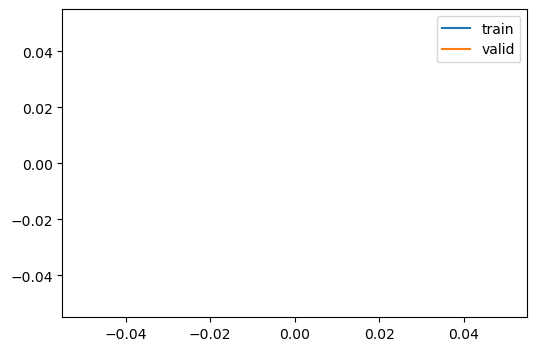

Keyboard interrupt, testing one last time... Press stop again to cancel.
test loss: min: nan; max: nan; last: nan
time: min: 2.1721; max: 13.9690; last: 13.9690
lr: min: 0.0010; max: 0.0010; last: 0.0010
train loss: min: nan; max: nan; last: nan


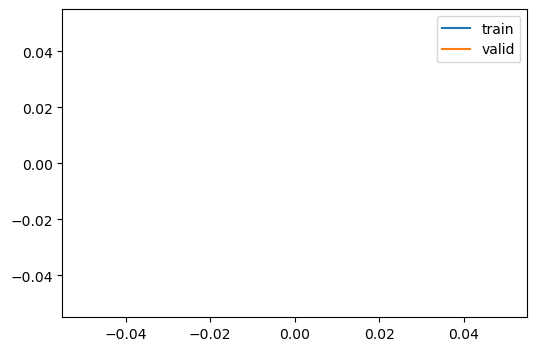

invalid value encountered in cast


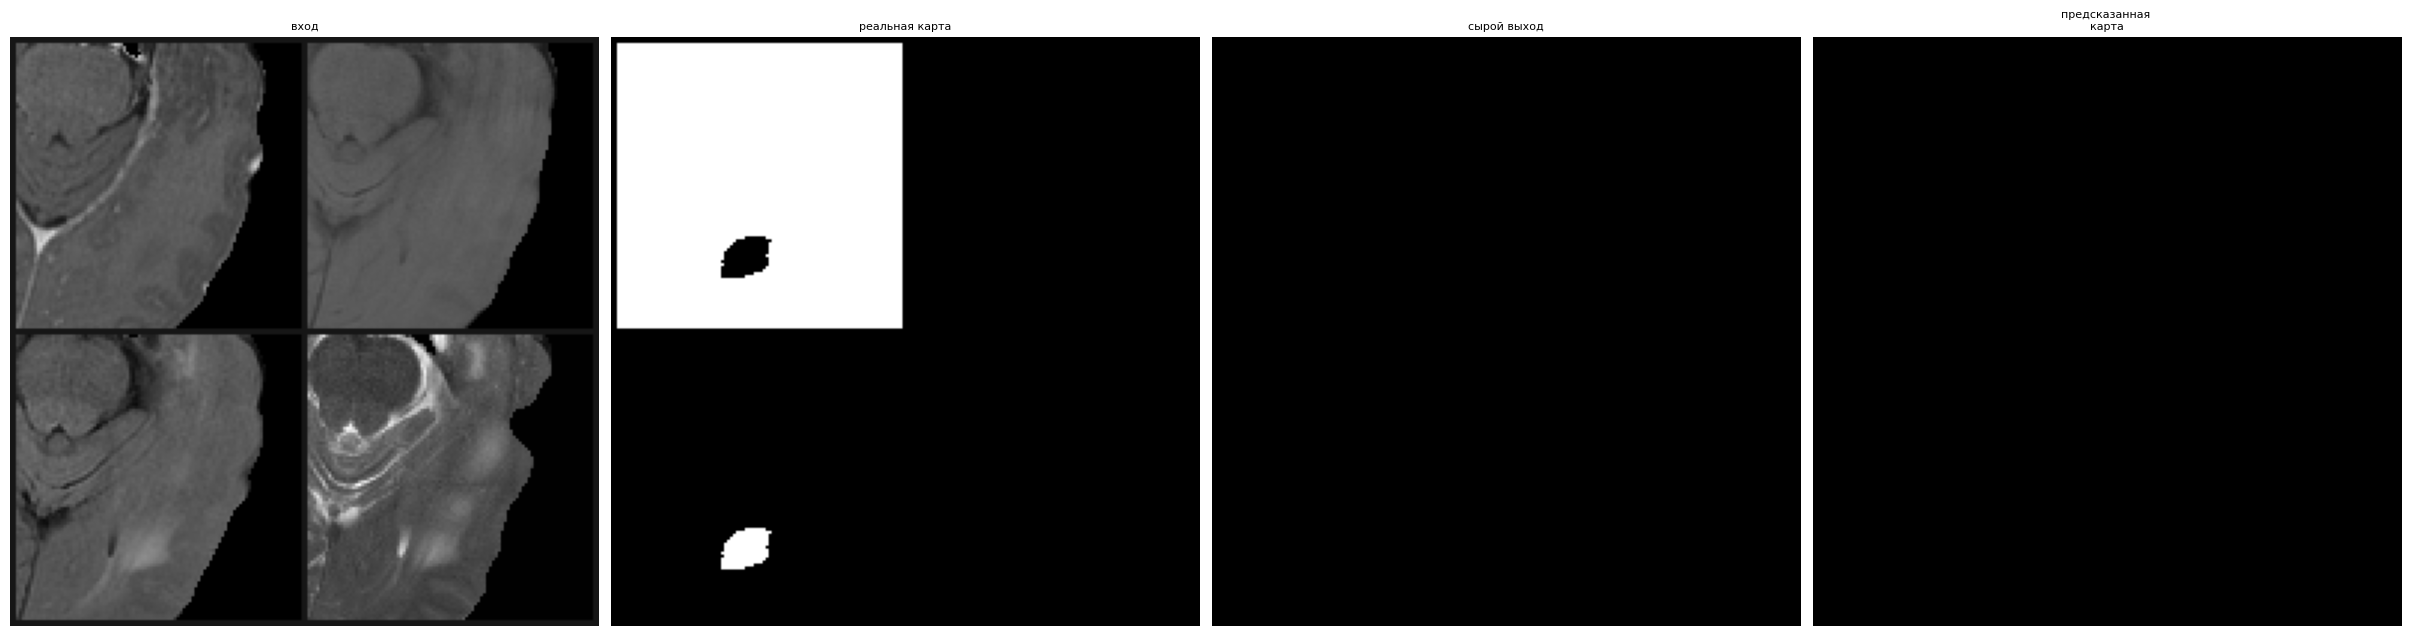

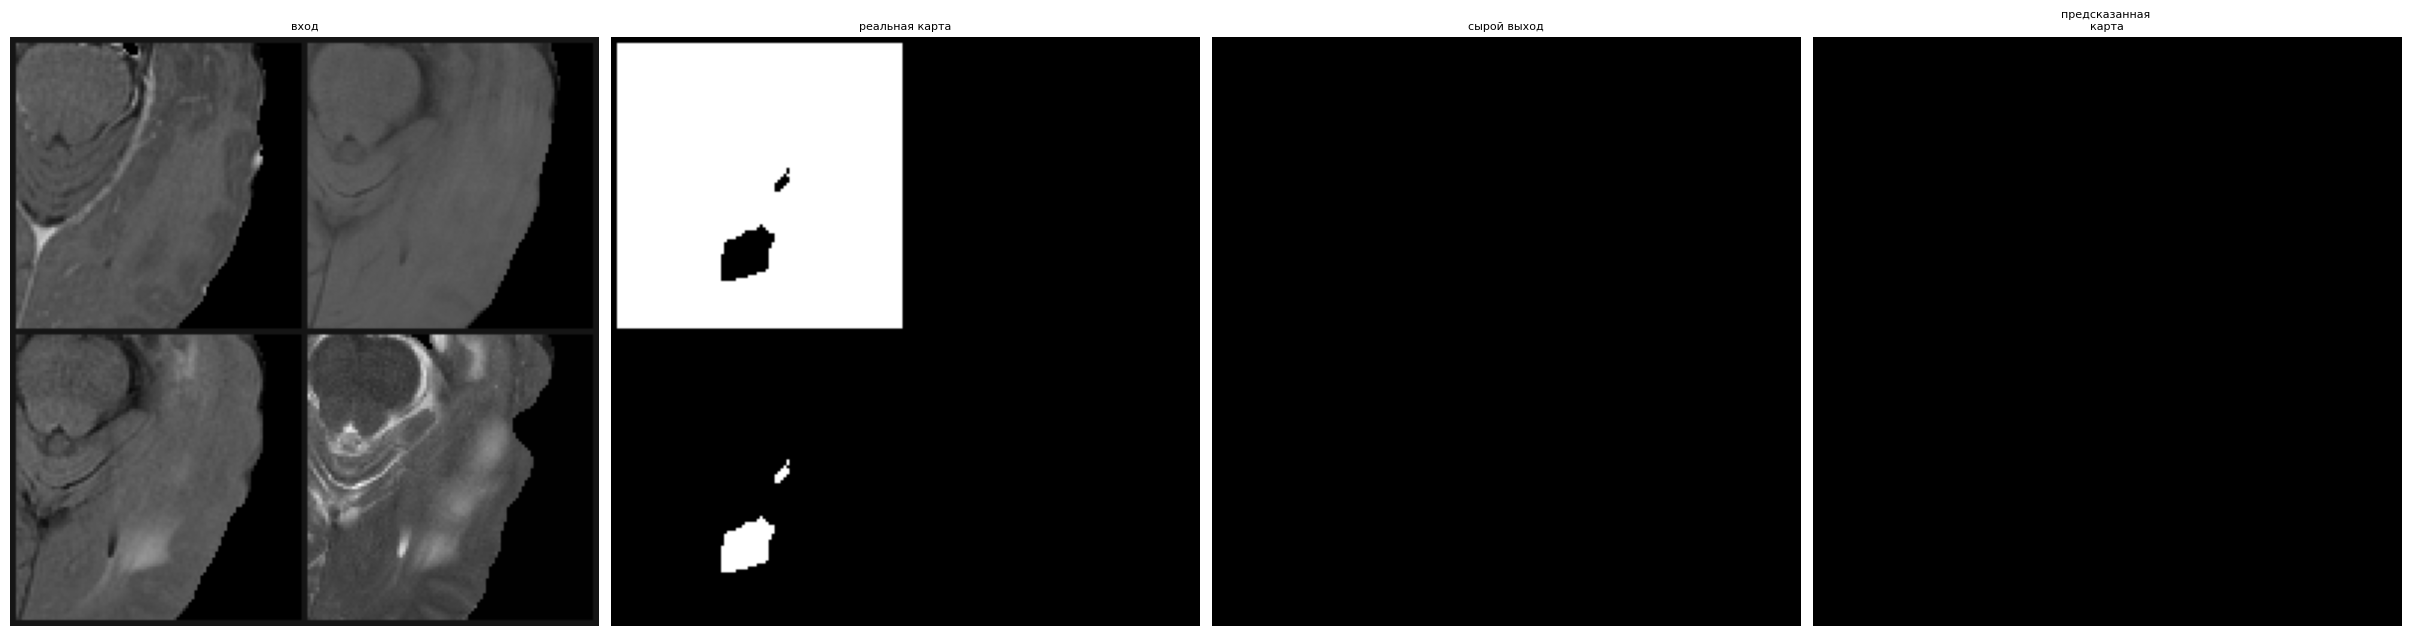

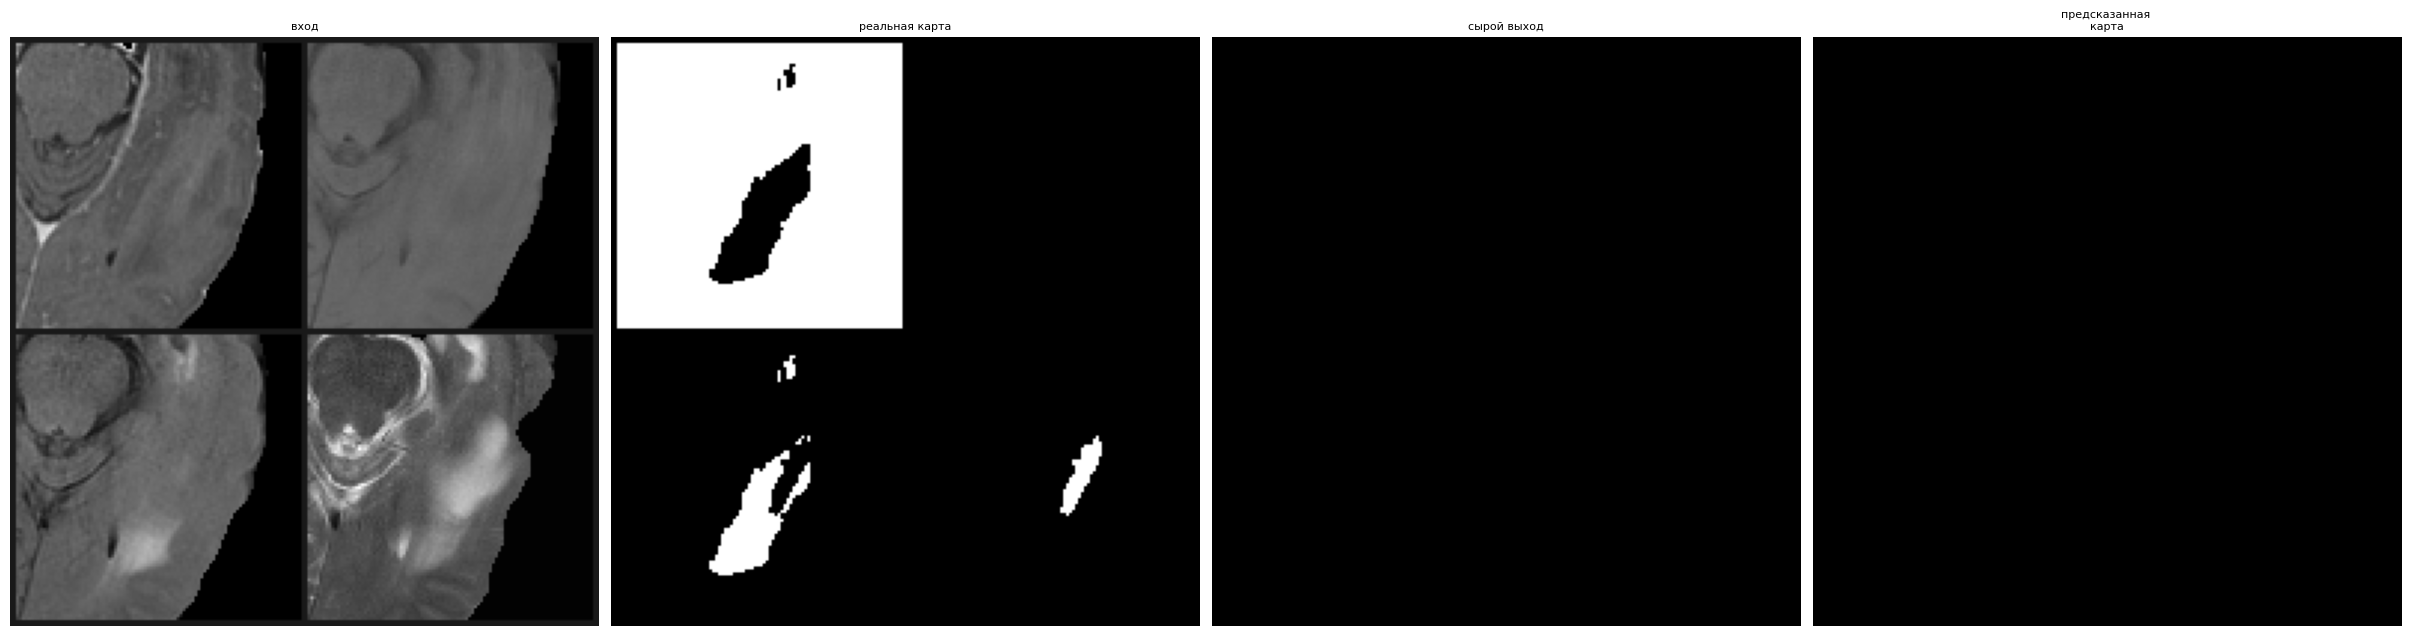

In [4]:
MODEL = SegResNetDS(2, in_channels=13, out_channels=4, init_filters=24)
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-3
BATCH_SIZE = 64
N_EPOCHS = 100

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = AdamWScheduleFree(MODEL.parameters(), lr=LR, eps=1e-6)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()
MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

LEARNER_NAME = f"{NAME} lr={LR} bs={BATCH_SIZE} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16),
                         Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), Summary(), Accelerate("no"),
                         Metric_PredsTargetsFn(DiceLoss(softmax=True), step=4, name="dice loss"), Metric_Accuracy(True, True, True),
                         Metric_PredsTargetsFn(lambda x,y:compute_iou(to_binary(F.softmax(x[:,1:], 1)), y[:,1:]).nanmean(), step=8, name = "iou"),
                         Metric_PredsTargetsFn(lambda x,y:compute_dice(to_binary(F.softmax(x[:,1:], 1)), y[:,1:]).nanmean(), step=8, name="dice coeff"),
                         FastProgressBar(plot=True, step_batch=16, metrics=
                                         ["train loss", "test loss", "train dice coeff", "test dice coeff", "train iou", "test iou"]),
                         ),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest)

plt.show()
plot_preds(learner, dstrain[3], softmax=True)
plot_preds(learner, dstrain[4], softmax=True)
plot_preds(learner, dstrain[6], softmax=True)


In [ ]:
learner.fit(N_EPOCHS, dltrain, dltest, extra=Set_Optimizer(optim.RAdam(MODEL.parameters(), 1e-4)))

plt.show()
plot_preds(learner, dstrain[3], softmax=True)
plot_preds(learner, dstrain[4], softmax=True)
plot_preds(learner, dstrain[6], softmax=True)